In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Microphone Locations
mic_height = 50.3125
feet = 12
y_tile = 23.5
x_tile = 11 +7/8

camera_origin_location = np.array([-6*x_tile-5.75, -y_tile, 45+13/16])*25.4

mic_1 = np.array([-11*x_tile - 1, -5*y_tile - 6-3/8, mic_height]) * 25.4 
mic_4= np.array([-11*x_tile + 1.25 + 1/16, 2.5*y_tile+3.75, mic_height]) * 25.4
mic_6 = np.array([5+3/8, 2+1/8, mic_height]) * 25.4
mic_9 = np.array([-3, -6*y_tile - 0.5, mic_height]) * 25.4

mic_xyzs = np.stack((mic_1,mic_4, mic_6, mic_9),axis=0)

In [3]:
SPEAKER_BOTTOM_RIGHT_Y = (1200.15 + 1196.975 + 1206.5)/ 3
SPEAKER_BOTTOM_RIGHT_X = (88.9 + 107.95 + 101.6) / 3
SPEAKER_BOTTOM_LEFT_Y = (1327.15 + 1311.55712764 + 1317.625) / 3
SPEAKER_BOTTOM_LEFT_X = - 76.98583188

speaker_xyz_bottom_right = np.array([SPEAKER_BOTTOM_RIGHT_X, SPEAKER_BOTTOM_RIGHT_Y, 44.5*25.4])
speaker_xyz_bottom_left = np.array([SPEAKER_BOTTOM_LEFT_X, SPEAKER_BOTTOM_LEFT_Y, 44.5*25.4])
speaker_xyz_top_right = np.array([SPEAKER_BOTTOM_RIGHT_X, SPEAKER_BOTTOM_RIGHT_Y, (44.5+17)*25.4])
speaker_xyz_top_left = np.array([SPEAKER_BOTTOM_LEFT_X, SPEAKER_BOTTOM_LEFT_Y, (44.5+17)*25.4])
speaker_xyz = (speaker_xyz_bottom_right+speaker_xyz_bottom_left+speaker_xyz_top_right+speaker_xyz_top_left)/4

In [4]:
walls = None
x_min = - 4000
x_max = 500
y_min = -4000
y_max = 2000

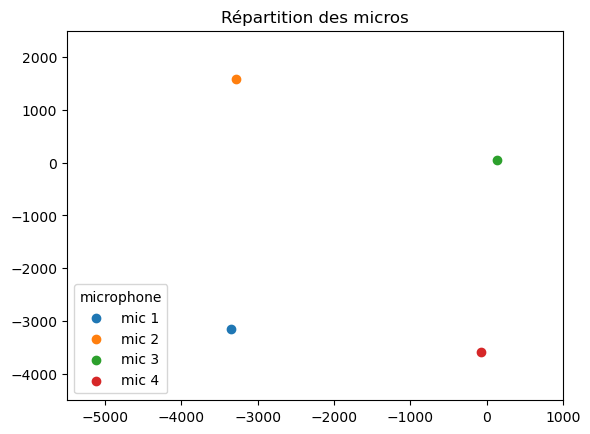

In [5]:
for idx, mic in enumerate(mic_xyzs):
    plt.scatter(mic[0], mic[1], label=f'mic {idx+1}')

plt.title("Répartition des micros")
plt.xlim([-5500, 1000])
plt.ylim([-4500, 2500])
plt.legend(loc="lower left", title="microphone")

In [9]:
rirs = np.load('../hackathon-minarm-2024/data/LivingRoom_preprocessed_hack/Human1/deconvoled_trim.npy')

In [10]:
localisations = np.load('../hackathon-minarm-2024/data/LivingRoom_preprocessed_hack/Human1/centroid.npy')

In [12]:
print(rirs.shape)
print(localisations.shape)
N_datapoints, N_mics, N_samples = rirs.shape
print(N_samples)

(1000, 4, 667200)
(1000, 2)
667200


In [42]:
rms = np.sqrt(np.square(rirs).mean(axis=2))

In [45]:
print(rms)

[[0.00052505 0.00050232 0.00070836 0.00042991]
 [0.00052084 0.00049965 0.00070709 0.0004291 ]
 [0.00052198 0.00049891 0.00070534 0.00042922]
 ...
 [0.0005181  0.00049532 0.00068871 0.00042133]
 [0.00051583 0.00049072 0.0006886  0.00041962]
 [0.00051578 0.00049757 0.00041044 0.00035783]]
